In [1]:
import glob
import matplotlib.pyplot as plt
from src.experiment_logging.log_analyzer import LogAnalyzer
from src.experiment_logging.experiment_log import *
from src.datetime import get_current_timestamp

%load_ext autoreload
%autoreload 2

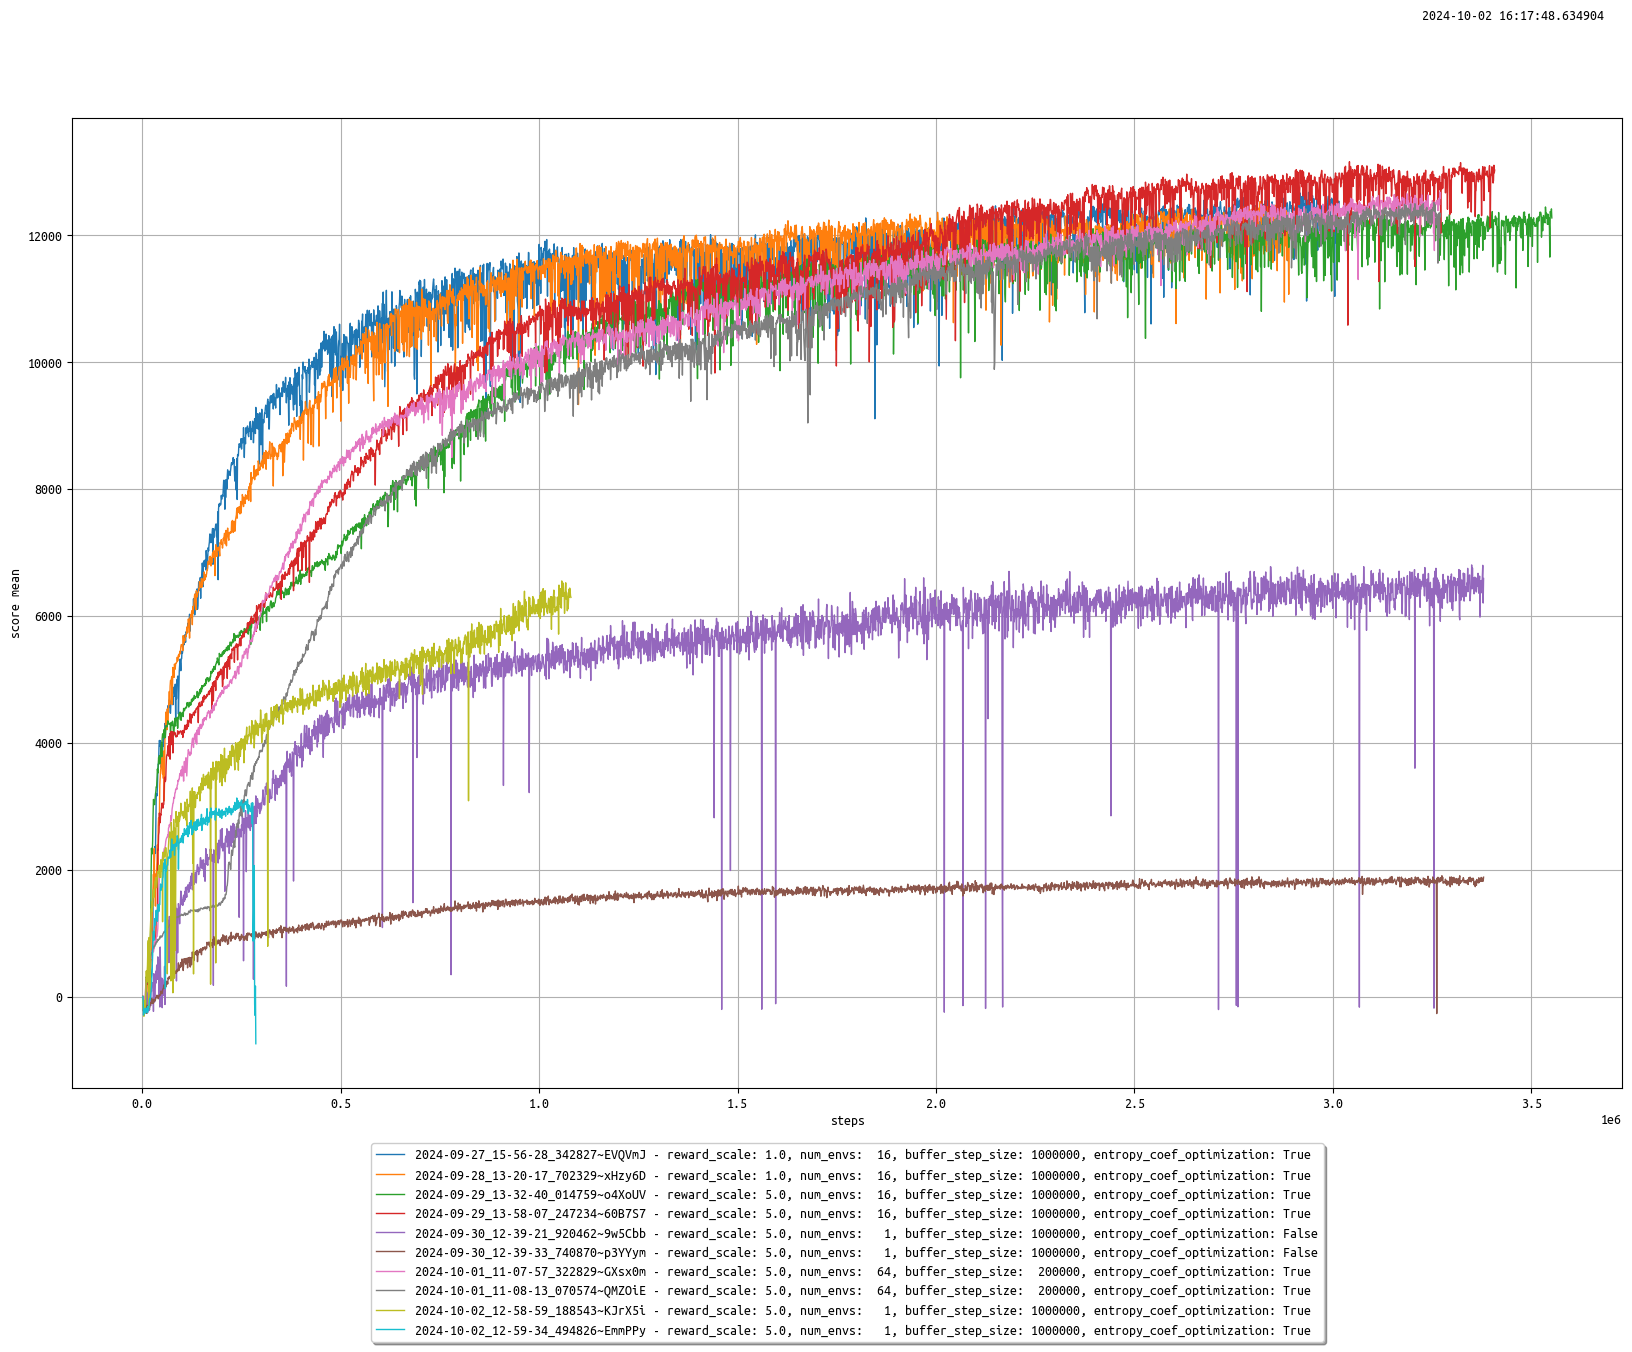

In [10]:

la = LogAnalyzer()
la.load_log_folder(
    'experiment_logs/HalfCheetah-v4/sac/',
    log_filter=lambda log: '__default' in log['logs_by_category']
)

plt.rcParams["font.family"] = "monospace"
plt.rcParams["font.monospace"] = ["Ubuntu Mono"]
fig: plt.Figure
ax: plt.Axes
fig, ax = plt.subplots(figsize=(20, 14))

fig.text(.8, .95, get_current_timestamp())

def get_label(log: ExperimentLog):
    values = {
        'reward_scale': log['hyper_parameters']['buffer']['reward_scale'],
        'num_envs': f"{log['hyper_parameters']['num_envs']:3d}",
        'buffer_step_size': f"{log['hyper_parameters']['buffer']['step_size']:7d}",
        'entropy_coef_optimization': log['hyper_parameters']['entropy_coef'] == 'dynamic'
    }
    
    return f"{log['experiment_id']} - {', '.join([f'{k}: {v}' for k, v in values.items()])}"

ax.grid()
ax.set(xlabel='steps', ylabel='score mean')
la.plot_logs(
    lambda item: item['step'], 
    lambda item: item['scores']['mean'] if item['scores'] is not None else 0 ,
    ax=ax,
    get_label=get_label,
    linewidth=1,
)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.10, box.width, box.height * 0.90])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          ncol=1, fancybox=True, shadow=True)
# fig.show()

In [2]:
la = LogAnalyzer()
la.load_log_folder(
    'experiment_logs/HalfCheetah-v4/sac/',
    # log_filter=lambda log: max(item['step'] for item in get_log_items(log)) > 5e1
)

for id, diff in la.find_hyper_parameter_diffs():
    print(f'{id}:')
    print(json.dumps(diff, indent=4))
    print('\n')
    

2024-09-28_13-20-17_702329~xHzy6D:
{}


2024-09-29_13-32-40_014759~o4XoUV:
{
    "buffer": {
        "reward_scale": [
            1.0,
            5.0
        ]
    }
}


2024-09-29_13-58-07_247234~60B7S7:
{
    "buffer": {
        "reward_scale": [
            1.0,
            5.0
        ]
    }
}


2024-09-30_12-39-21_920462~9w5Cbb:
{
    "entropy_coef": [
        "dynamic",
        1.0
    ],
    "env_specs": [
        {
            "_count": [
                16,
                1
            ]
        }
    ],
    "entropy_coef_optimizer": [
        {
            "_type": "Adam",
            "_type_fq": "torch.optim.adam.Adam",
            "...": "..."
        },
        null
    ],
    "num_envs": [
        16,
        1
    ],
    "buffer": {
        "num_envs": [
            16,
            1
        ],
        "total_size": [
            16000000,
            1000000
        ],
        "reward_scale": [
            1.0,
            5.0
        ]
    }
}


2024-09-30_12-39-33

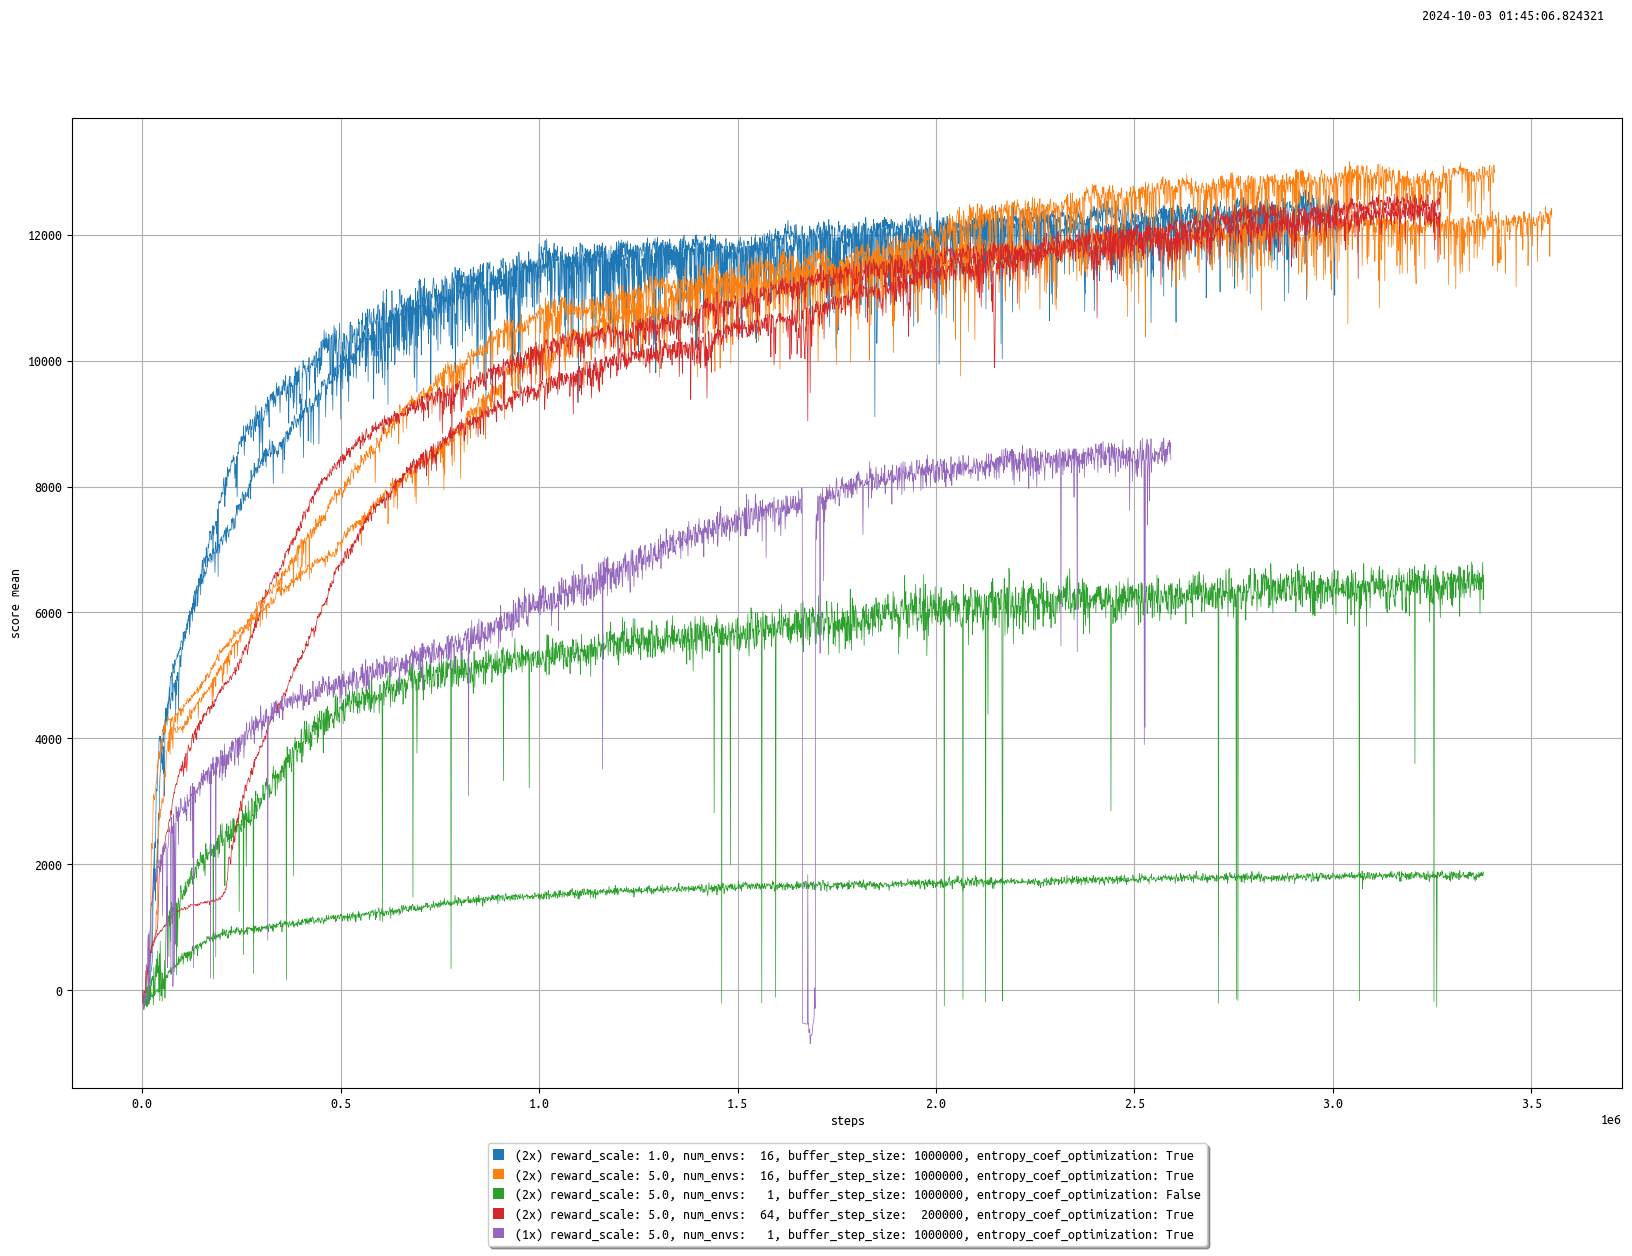

In [38]:
from matplotlib.patches import Patch

la = LogAnalyzer()
la.load_log_folder(
    'experiment_logs/HalfCheetah-v4/sac/',
    log_filter=lambda log: '__default' in log['logs_by_category']
)

plt.rcParams["font.family"] = "monospace"
plt.rcParams["font.monospace"] = ["Ubuntu Mono"]
fig: plt.Figure
ax: plt.Axes
fig, ax = plt.subplots(figsize=(20, 14))

fig.text(.8, .95, get_current_timestamp())

def get_log_group(log: ExperimentLog):
    values = {
        'reward_scale': log['hyper_parameters']['buffer']['reward_scale'],
        'num_envs': f"{log['hyper_parameters']['num_envs']:3d}",
        'buffer_step_size': f"{log['hyper_parameters']['buffer']['step_size']:7d}",
        'entropy_coef_optimization': log['hyper_parameters']['entropy_coef'] == 'dynamic'
    }
    
    return ', '.join([f'{k}: {v}' for k, v in values.items()])

ax.grid()
ax.set(xlabel='steps', ylabel='score mean')
la.plot_logs_grouped(
    lambda item: item['step'], 
    lambda item: item['scores']['mean'] if item['scores'] is not None else 0 ,
    get_log_group=get_log_group,
    ax=ax,
    plot_individual=True,
    mean_plot_kwargs={'linewidth': 0.0},
    fill_plot_kwargs={'alpha': 0}
)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.10, box.width, box.height * 0.90])

handles, labels = plt.gca().get_legend_handles_labels()

new_handles = [
    Patch(facecolor=handle.get_color(), label=label)
    for handle, label in zip(handles, labels, strict=True)
]

ax.legend(handles=new_handles, 
           handlelength=0.8, handleheight=0.8, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          ncol=1, fancybox=True, shadow=True)
# fig.show()

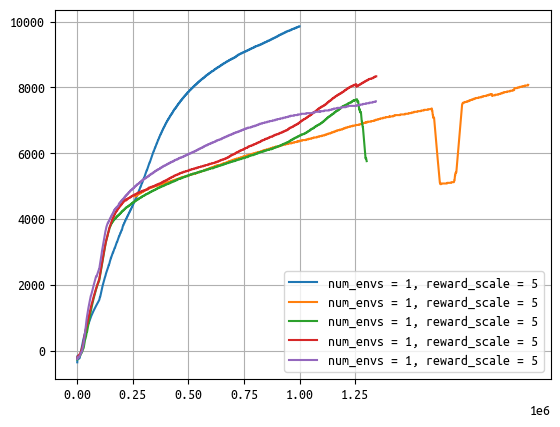

In [36]:
import re
import matplotlib.pyplot as plt

fig, ax = plt.subplots()


for data_file in glob.glob('experiment_logs/HalfCheetah-v4/sac_sb3/*.txt'):

    # Initialize variables
    entries = []
    current_entry = {}
    in_entry = False

    with open(data_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('---'):
                # Toggle the in_entry flag
                if in_entry:
                    # We're ending an entry
                    entries.append(current_entry)
                    current_entry = {}
                in_entry = not in_entry
            elif in_entry:
                # We're inside an entry
                if line.startswith('|'):
                    # Remove leading and trailing '|', then split by '|'
                    parts = [part.strip() for part in line.strip('|').split('|')]
                    if len(parts) >= 2:
                        key = parts[0]
                        value = parts[1]
                        if key == 'n_updates':
                            current_entry['n_updates'] = value
                        elif key == 'ep_rew_mean':
                            current_entry['ep_rew_mean'] = value

    # # Print the extracted data
    # for idx, entry in enumerate(entries, start=1):
    #     n_updates = entry.get('n_updates', 'N/A')
    #     ep_rew_mean = entry.get('ep_rew_mean', 'N/A')
    #     print(f"Entry {idx}: n_updates = {n_updates}, ep_rew_mean = {ep_rew_mean}")
    
    label = f'num_envs = {16 if "16envs" in data_file else 1}'

    has_reward_scale = "5reward_scale" in data_file
    label += f', reward_scale = {5 if has_reward_scale else 1}'
    
    if 'reward_scale = 5' not in label:
        continue
    
    ax.plot(
        [int(entry['n_updates']) for entry in entries],
        [float(entry['ep_rew_mean']) / (5 if has_reward_scale else 1) for entry in entries],
        label=label
    )

ax.set_xticks([_ * 250000 for _ in range(6)])
ax.grid(True)
ax.legend()
